# State Reconstruction after two-qubit channel application

In [1]:
import numpy as np
import scipy as sp
import scipy.linalg
import matplotlib.pyplot as plt
import qiskit as qk
import qiskit.visualization

from qiskit import Aer
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector

from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit import transpile
from qiskit.quantum_info.operators import Operator

from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import amplitude_damping_error
from qiskit.providers.aer.noise import kraus_error

import tensorflow as tf
print("TensorFlow version:", tf.__version__)
from tensorflow.python.framework.ops import convert_to_tensor

TensorFlow version: 2.11.0


In [2]:
#Ensure reproducibility
np.random.seed(123)
tf.random.set_seed(123)
import random
random.seed(10)

## Data Generation

In [3]:
# Generation of a random unitary transformation
def random_unitary(N):
    Z=np.random.randn(N,N) + 1.0j * np.random.randn(N,N)
    [Q,R]=sp.linalg.qr(Z)
    D=np.diag(np.diagonal(R)/np.abs(np.diagonal(R)))
    return np.dot(Q,D)

In [4]:
#Function which generates the density matrix given the state vector
def get_density_matrix(state_vector):
    density_matrix = np.outer(state_vector, np.conjugate(state_vector))
    return density_matrix

In [7]:
#Choice of the simulator
sim_bknd=Aer.get_backend('aer_simulator')

In [8]:
def generate_Haar_data(num_qubits, samples=1000):
    data = []
    for i in range(samples):
        qc = qk.QuantumCircuit(num_qubits) #creates a quantum circuit with "num_qubits" qubits
        u = random_unitary(2**num_qubits)
        qc.unitary(u, qubits=range(num_qubits)) #applies the random unitary transformation to the circuit
        qc = qk.transpile(qc, backend=sim_bknd) #it's used to optimize the circuit
        qc.save_statevector() #it's the instruction to save the state vector obtained by the simulation

        state = sim_bknd.run(qc).result().get_statevector(qc) #does the simulation and gets the state vector
        state = np.asarray(state)
        data.append(state) 
    return data

## Useful Functions

In [11]:
#function which returns bloch components from density matrix
def bloch_coeffs(rho):
    c = []
    for p in pauli_basis2q_modified:
        c.append(np.trace(rho @ p))
    return np.array(c)

In [12]:
#function which returns density matrix from bloch components
def rho_from_coeffs(coeffs):
    rho = 0.25 * np.sum([c * p for c,p in zip(coeffs, pauli_basis2q)], axis=0)
    return rho

In [10]:
I_4 = tf.constant([[1.0, 0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0]],shape=(4,4), dtype = tf.complex64)
pauli_basis1q = np.array([I, X, Y, Z])
pauli_basis2q = np.array([np.kron(a,b) for a in pauli_basis1q for b in pauli_basis1q])
pauli_basis2q_modified = pauli_basis2q[1:]


def fid_twoq(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk', pauli_basis2q_modified, a)
   el_b = tf.einsum('ijk,mi->mjk', pauli_basis2q_modified, b)
   rho_a = 0.25 *(el_a + I_4)
   rho_b = 0.25 * (el_b +I_4)
   fidelity = tf.linalg.trace(tf.linalg.sqrtm(tf.linalg.sqrtm(rho_a) @ rho_b @ tf.linalg.sqrtm(rho_a))) **2
   return fidelity 

In [13]:
@tf.function
def infidelity(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk',pauli_basis2q_modified,a) 
   el_b = tf.einsum('ijk,mi->mjk',pauli_basis2q_modified,b) 
   rho_a = 0.25 *(el_a + I_4)
   rho_b = 0.25 * (el_b +I_4)
   fidelity = tf.linalg.trace(tf.linalg.sqrtm(tf.linalg.sqrtm(rho_a) @ rho_b @ tf.linalg.sqrtm(rho_a))) **2
   infidelity = 1 - fidelity
   infidelity = tf.cast(infidelity, dtype = tf.float32)
   return infidelity 

## Noise Model 

In [14]:
#SINGLE ELEMENT OF THE OPERATOR-SUM REPRESENTATION

def sum_element(rho,operator):
    element = np.dot(np.dot(operator,rho),operator.conj().T)
    return element

In [15]:
#CORRELATED TWO-QUBIT AMPLITUDE DAMPING CHANNEL

def corr_twoq_ad(num_qubits, rho, eta, mu):
    
    E_0 = np.array([[1, 0], [0, np.sqrt(eta)]])
    E_1 = np.array([[0, np.sqrt(1 - eta)], [0, 0]])
    
    A_0 = np.kron(E_0, E_0)
    A_1 = np.kron(E_0, E_1)
    A_2 = np.kron(E_1, E_0)
    A_3 = np.kron(E_1, E_1)


    B_0 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, np.sqrt(eta)]])
    B_1 = np.array([[0, 0, 0, np.sqrt(1 - eta)], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])

    N_0 = sum_element(rho, A_0) + sum_element(rho, A_1) + sum_element(rho, A_2) + sum_element(rho, A_3)
    N_1 = sum_element(rho, B_0) + sum_element(rho, B_1)

    noisy_rho = (1 - mu) * N_0 + mu * N_1
    return noisy_rho

## Training the Algorithm

In [50]:
data = generate_Haar_data(2, 10000) 
density_matrix_noise_free = [*map(get_density_matrix, data)] 
bloch_vectors_noise_free = [*map(bloch_coeffs, density_matrix_noise_free)]

In [51]:
#APPLY ERROR 
density_matrix_with_noise = []
for i in range(len(data)):
    single_data_with_noise = corr_twoq_ad(2, density_matrix_noise_free[i], 0.1, 0.2)
    density_matrix_with_noise.append(single_data_with_noise)

#PRINT THE TYPE OF THE SINGLE DENSITY MATRIX IN THE LISTS OF THE DENSITY MATRICES WITH NOISE
print("Density matrix with noise type:", density_matrix_with_noise[0].dtype)

#COMPUTE_BLOCH VECTOR WITH NOISE
bloch_vectors_with_noise = [*map(bloch_coeffs, density_matrix_with_noise)]
print("Bloch vector with noise type:", bloch_vectors_with_noise[0].dtype)

Density matrix with noise type: complex128
Bloch vector with noise type: complex128


## <font color='red'>MSE</font>

In [18]:
x_train_list = bloch_vectors_with_noise[:700]
y_train_list = bloch_vectors_noise_free[:700]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = bloch_vectors_with_noise[800:900]
y_val_list = bloch_vectors_noise_free[800:900]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = bloch_vectors_with_noise[900:1000]
y_test_list = bloch_vectors_noise_free[900:1000]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [21]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),                                 
  #tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(15)
  ])

In [22]:
# Define Loss
loss_fn = tf.keras.losses.mse
# Compile model
adam_opt = tf.optimizers.Adam(0.0003)
model.compile(optimizer=adam_opt,
              loss=loss_fn)

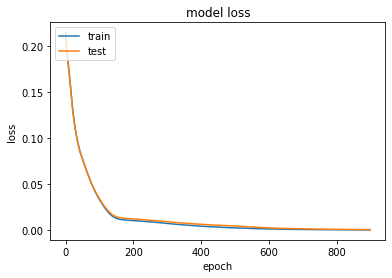

In [25]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=100, epochs=900)

Epoch 1/900
7/7 [==============================] - 2s 76ms/step - loss: 0.2147 - val_loss: 0.2110
Epoch 2/900
7/7 [==============================] - 0s 11ms/step - loss: 0.2060 - val_loss: 0.2034
Epoch 3/900
7/7 [==============================] - 0s 13ms/step - loss: 0.2001 - val_loss: 0.1982
Epoch 4/900
7/7 [==============================] - 0s 15ms/step - loss: 0.1959 - val_loss: 0.1942
Epoch 5/900
7/7 [==============================] - 0s 12ms/step - loss: 0.1923 - val_loss: 0.1908
Epoch 6/900
7/7 [==============================] - 0s 12ms/step - loss: 0.1892 - val_loss: 0.1876
Epoch 7/900
7/7 [==============================] - 0s 11ms/step - loss: 0.1862 - val_loss: 0.1844
Epoch 8/900
7/7 [==============================] - 0s 11ms/step - loss: 0.1831 - val_loss: 0.1813
Epoch 9/900
7/7 [==============================] - 0s 12ms/step - loss: 0.1798 - val_loss: 0.1779
Epoch 10/900
7/7 [==============================] - 0s 12ms/step - loss: 0.1764 - val_loss: 0.1745
Epoch 11/900
7/7 [=

Epoch 84/900
7/7 [==============================] - 0s 13ms/step - loss: 0.0450 - val_loss: 0.0457
Epoch 85/900
7/7 [==============================] - 0s 12ms/step - loss: 0.0443 - val_loss: 0.0448
Epoch 86/900
7/7 [==============================] - 0s 12ms/step - loss: 0.0435 - val_loss: 0.0441
Epoch 87/900
7/7 [==============================] - 0s 11ms/step - loss: 0.0428 - val_loss: 0.0435
Epoch 88/900
7/7 [==============================] - 0s 12ms/step - loss: 0.0421 - val_loss: 0.0427
Epoch 89/900
7/7 [==============================] - 0s 11ms/step - loss: 0.0413 - val_loss: 0.0420
Epoch 90/900
7/7 [==============================] - 0s 13ms/step - loss: 0.0407 - val_loss: 0.0415
Epoch 91/900
7/7 [==============================] - 0s 12ms/step - loss: 0.0400 - val_loss: 0.0406
Epoch 92/900
7/7 [==============================] - 0s 12ms/step - loss: 0.0392 - val_loss: 0.0399
Epoch 93/900
7/7 [==============================] - 0s 12ms/step - loss: 0.0386 - val_loss: 0.0394
Epoch 94/9

7/7 [==============================] - 0s 24ms/step - loss: 0.0117 - val_loss: 0.0135
Epoch 167/900
7/7 [==============================] - 0s 11ms/step - loss: 0.0116 - val_loss: 0.0135
Epoch 168/900
7/7 [==============================] - 0s 13ms/step - loss: 0.0116 - val_loss: 0.0135
Epoch 169/900
7/7 [==============================] - 0s 11ms/step - loss: 0.0115 - val_loss: 0.0133
Epoch 170/900
7/7 [==============================] - 0s 13ms/step - loss: 0.0115 - val_loss: 0.0133
Epoch 171/900
7/7 [==============================] - 0s 14ms/step - loss: 0.0115 - val_loss: 0.0134
Epoch 172/900
7/7 [==============================] - 0s 13ms/step - loss: 0.0114 - val_loss: 0.0132
Epoch 173/900
7/7 [==============================] - 0s 12ms/step - loss: 0.0114 - val_loss: 0.0134
Epoch 174/900
7/7 [==============================] - 0s 11ms/step - loss: 0.0113 - val_loss: 0.0131
Epoch 175/900
7/7 [==============================] - 0s 12ms/step - loss: 0.0113 - val_loss: 0.0131
Epoch 176/900


7/7 [==============================] - 0s 12ms/step - loss: 0.0093 - val_loss: 0.0111
Epoch 249/900
7/7 [==============================] - 0s 10ms/step - loss: 0.0093 - val_loss: 0.0111
Epoch 250/900
7/7 [==============================] - 0s 11ms/step - loss: 0.0093 - val_loss: 0.0111
Epoch 251/900
7/7 [==============================] - 0s 10ms/step - loss: 0.0093 - val_loss: 0.0110
Epoch 252/900
7/7 [==============================] - 0s 11ms/step - loss: 0.0092 - val_loss: 0.0110
Epoch 253/900
7/7 [==============================] - 0s 11ms/step - loss: 0.0092 - val_loss: 0.0110
Epoch 254/900
7/7 [==============================] - 0s 12ms/step - loss: 0.0092 - val_loss: 0.0109
Epoch 255/900
7/7 [==============================] - 0s 12ms/step - loss: 0.0091 - val_loss: 0.0109
Epoch 256/900
7/7 [==============================] - 0s 12ms/step - loss: 0.0091 - val_loss: 0.0109
Epoch 257/900
7/7 [==============================] - 0s 12ms/step - loss: 0.0091 - val_loss: 0.0108
Epoch 258/900


7/7 [==============================] - 0s 12ms/step - loss: 0.0066 - val_loss: 0.0085
Epoch 331/900
7/7 [==============================] - 0s 11ms/step - loss: 0.0066 - val_loss: 0.0085
Epoch 332/900
7/7 [==============================] - 0s 11ms/step - loss: 0.0065 - val_loss: 0.0084
Epoch 333/900
7/7 [==============================] - 0s 16ms/step - loss: 0.0064 - val_loss: 0.0084
Epoch 334/900
7/7 [==============================] - 0s 15ms/step - loss: 0.0064 - val_loss: 0.0083
Epoch 335/900
7/7 [==============================] - 0s 11ms/step - loss: 0.0064 - val_loss: 0.0083
Epoch 336/900
7/7 [==============================] - 0s 11ms/step - loss: 0.0064 - val_loss: 0.0083
Epoch 337/900
7/7 [==============================] - 0s 11ms/step - loss: 0.0063 - val_loss: 0.0083
Epoch 338/900
7/7 [==============================] - 0s 10ms/step - loss: 0.0063 - val_loss: 0.0083
Epoch 339/900
7/7 [==============================] - 0s 12ms/step - loss: 0.0063 - val_loss: 0.0083
Epoch 340/900


7/7 [==============================] - 0s 11ms/step - loss: 0.0043 - val_loss: 0.0064
Epoch 413/900
7/7 [==============================] - 0s 12ms/step - loss: 0.0043 - val_loss: 0.0064
Epoch 414/900
7/7 [==============================] - 0s 12ms/step - loss: 0.0043 - val_loss: 0.0063
Epoch 415/900
7/7 [==============================] - 0s 11ms/step - loss: 0.0042 - val_loss: 0.0062
Epoch 416/900
7/7 [==============================] - 0s 14ms/step - loss: 0.0042 - val_loss: 0.0062
Epoch 417/900
7/7 [==============================] - 0s 14ms/step - loss: 0.0042 - val_loss: 0.0063
Epoch 418/900
7/7 [==============================] - 0s 10ms/step - loss: 0.0042 - val_loss: 0.0062
Epoch 419/900
7/7 [==============================] - 0s 11ms/step - loss: 0.0042 - val_loss: 0.0062
Epoch 420/900
7/7 [==============================] - 0s 11ms/step - loss: 0.0042 - val_loss: 0.0062
Epoch 421/900
7/7 [==============================] - 0s 11ms/step - loss: 0.0041 - val_loss: 0.0062
Epoch 422/900


7/7 [==============================] - 0s 12ms/step - loss: 0.0028 - val_loss: 0.0048
Epoch 495/900
7/7 [==============================] - 0s 11ms/step - loss: 0.0028 - val_loss: 0.0049
Epoch 496/900
7/7 [==============================] - 0s 16ms/step - loss: 0.0028 - val_loss: 0.0048
Epoch 497/900
7/7 [==============================] - 0s 14ms/step - loss: 0.0028 - val_loss: 0.0048
Epoch 498/900
7/7 [==============================] - 0s 11ms/step - loss: 0.0028 - val_loss: 0.0048
Epoch 499/900
7/7 [==============================] - 0s 15ms/step - loss: 0.0027 - val_loss: 0.0047
Epoch 500/900
7/7 [==============================] - 0s 13ms/step - loss: 0.0027 - val_loss: 0.0048
Epoch 501/900
7/7 [==============================] - 0s 12ms/step - loss: 0.0027 - val_loss: 0.0047
Epoch 502/900
7/7 [==============================] - 0s 16ms/step - loss: 0.0027 - val_loss: 0.0047
Epoch 503/900
7/7 [==============================] - 0s 12ms/step - loss: 0.0027 - val_loss: 0.0046
Epoch 504/900


7/7 [==============================] - 0s 18ms/step - loss: 0.0019 - val_loss: 0.0033
Epoch 577/900
7/7 [==============================] - 0s 16ms/step - loss: 0.0019 - val_loss: 0.0032
Epoch 578/900
7/7 [==============================] - 0s 12ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 579/900
7/7 [==============================] - 0s 18ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 580/900
7/7 [==============================] - 0s 16ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 581/900
7/7 [==============================] - 0s 11ms/step - loss: 0.0018 - val_loss: 0.0032
Epoch 582/900
7/7 [==============================] - 0s 15ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 583/900
7/7 [==============================] - 0s 10ms/step - loss: 0.0018 - val_loss: 0.0030
Epoch 584/900
7/7 [==============================] - 0s 12ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 585/900
7/7 [==============================] - 0s 15ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 586/900


7/7 [==============================] - 0s 16ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 659/900
7/7 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 660/900
7/7 [==============================] - 0s 13ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 661/900
7/7 [==============================] - 0s 13ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 662/900
7/7 [==============================] - 0s 12ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 663/900
7/7 [==============================] - 0s 12ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 664/900
7/7 [==============================] - 0s 13ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 665/900
7/7 [==============================] - 0s 13ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 666/900
7/7 [==============================] - 0s 12ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 667/900
7/7 [==============================] - 0s 10ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 668/900


7/7 [==============================] - 0s 11ms/step - loss: 8.5046e-04 - val_loss: 0.0014
Epoch 739/900
7/7 [==============================] - 0s 15ms/step - loss: 8.2815e-04 - val_loss: 0.0014
Epoch 740/900
7/7 [==============================] - 0s 11ms/step - loss: 8.4224e-04 - val_loss: 0.0014
Epoch 741/900
7/7 [==============================] - 0s 10ms/step - loss: 8.2566e-04 - val_loss: 0.0014
Epoch 742/900
7/7 [==============================] - 0s 11ms/step - loss: 8.2300e-04 - val_loss: 0.0014
Epoch 743/900
7/7 [==============================] - 0s 11ms/step - loss: 8.2460e-04 - val_loss: 0.0015
Epoch 744/900
7/7 [==============================] - 0s 14ms/step - loss: 8.3274e-04 - val_loss: 0.0014
Epoch 745/900
7/7 [==============================] - 0s 12ms/step - loss: 8.2486e-04 - val_loss: 0.0014
Epoch 746/900
7/7 [==============================] - 0s 17ms/step - loss: 8.1769e-04 - val_loss: 0.0014
Epoch 747/900
7/7 [==============================] - 0s 14ms/step - loss: 8.00

Epoch 817/900
7/7 [==============================] - 0s 10ms/step - loss: 6.4159e-04 - val_loss: 0.0011
Epoch 818/900
7/7 [==============================] - 0s 10ms/step - loss: 6.5070e-04 - val_loss: 0.0011
Epoch 819/900
7/7 [==============================] - 0s 10ms/step - loss: 6.8256e-04 - val_loss: 0.0011
Epoch 820/900
7/7 [==============================] - 0s 10ms/step - loss: 6.6495e-04 - val_loss: 0.0011
Epoch 821/900
7/7 [==============================] - 0s 16ms/step - loss: 6.6578e-04 - val_loss: 0.0011
Epoch 822/900
7/7 [==============================] - 0s 18ms/step - loss: 6.4523e-04 - val_loss: 0.0011
Epoch 823/900
7/7 [==============================] - 0s 14ms/step - loss: 6.4326e-04 - val_loss: 0.0011
Epoch 824/900
7/7 [==============================] - 0s 11ms/step - loss: 6.4930e-04 - val_loss: 0.0011
Epoch 825/900
7/7 [==============================] - 0s 11ms/step - loss: 6.3750e-04 - val_loss: 0.0011
Epoch 826/900
7/7 [==============================] - 0s 10ms/ste

Epoch 895/900
7/7 [==============================] - 0s 15ms/step - loss: 5.3362e-04 - val_loss: 9.1661e-04
Epoch 896/900
7/7 [==============================] - 0s 11ms/step - loss: 5.3660e-04 - val_loss: 9.4553e-04
Epoch 897/900
7/7 [==============================] - 0s 16ms/step - loss: 5.2995e-04 - val_loss: 9.4106e-04
Epoch 898/900
7/7 [==============================] - 0s 17ms/step - loss: 5.3855e-04 - val_loss: 9.4774e-04
Epoch 899/900
7/7 [==============================] - 0s 15ms/step - loss: 5.2905e-04 - val_loss: 9.1114e-04
Epoch 900/900
7/7 [==============================] - 0s 17ms/step - loss: 5.3138e-04 - val_loss: 9.0493e-04


In [24]:
score = model.evaluate(x_test,  y_test, verbose=2)

4/4 - 0s - loss: 0.0011 - 189ms/epoch - 47ms/step


In [27]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_mse = tf.math.reduce_mean(fid)
print(fid_mse)

tf.Tensor((0.99250305-1.4007413e-05j), shape=(), dtype=complex64)


## <font color='green'>Training the Algorithm (INF)</font>

In [56]:
x_train_list = bloch_vectors_with_noise[:1000]
y_train_list = bloch_vectors_noise_free[:1000]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = bloch_vectors_with_noise[9000:9500]
y_val_list = bloch_vectors_noise_free[9000:9500]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = bloch_vectors_with_noise[9500:]
y_test_list = bloch_vectors_noise_free[9500:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [69]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),                                 
  tf.keras.layers.Dense(128, activation='relu'),
  #tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(15),
  tf.keras.layers.Lambda(lambda x:  tf.math.sqrt(3.0) * tf.math.l2_normalize(x, axis=1))
  ])

In [70]:
# Compile model
adam_opt = tf.optimizers.Adam(0.0002)
model.compile(optimizer=adam_opt,
              loss=infidelity)

In [ ]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=200, epochs=400)

Epoch 1/400
5/5 [==============================] - 2s 95ms/step - loss: 0.7321 - val_loss: 0.7366
Epoch 2/400
5/5 [==============================] - 0s 35ms/step - loss: 0.7184 - val_loss: 0.7246
Epoch 3/400
5/5 [==============================] - 0s 31ms/step - loss: 0.7067 - val_loss: 0.7124
Epoch 4/400
5/5 [==============================] - 0s 29ms/step - loss: 0.6939 - val_loss: 0.6988
Epoch 5/400
5/5 [==============================] - 0s 39ms/step - loss: 0.6795 - val_loss: 0.6837
Epoch 6/400
5/5 [==============================] - 0s 42ms/step - loss: 0.6630 - val_loss: 0.6670
Epoch 7/400
5/5 [==============================] - 0s 35ms/step - loss: 0.6442 - val_loss: 0.6474
Epoch 8/400
5/5 [==============================] - 0s 40ms/step - loss: 0.6227 - val_loss: 0.6256
Epoch 9/400
5/5 [==============================] - 0s 28ms/step - loss: 0.5975 - val_loss: 0.6010
Epoch 10/400
5/5 [==============================] - 0s 31ms/step - loss: 0.5708 - val_loss: 0.5738
Epoch 11/400
5/5 [=

Epoch 84/400
5/5 [==============================] - 0s 32ms/step - loss: 0.3157 - val_loss: 0.3177
Epoch 85/400
5/5 [==============================] - 0s 35ms/step - loss: 0.3162 - val_loss: 0.3180
Epoch 86/400
5/5 [==============================] - 0s 37ms/step - loss: 0.3155 - val_loss: 0.3169
Epoch 87/400
5/5 [==============================] - 0s 35ms/step - loss: 0.3137 - val_loss: 0.3148
Epoch 88/400
5/5 [==============================] - 0s 37ms/step - loss: 0.3112 - val_loss: 0.3123
Epoch 89/400
5/5 [==============================] - 0s 43ms/step - loss: 0.3084 - val_loss: 0.3080
Epoch 90/400
5/5 [==============================] - 0s 36ms/step - loss: 0.3029 - val_loss: 0.3026
Epoch 91/400
5/5 [==============================] - 0s 34ms/step - loss: 0.2983 - val_loss: 0.2987
Epoch 92/400
5/5 [==============================] - 0s 27ms/step - loss: 0.3000 - val_loss: 0.3108
Epoch 93/400
5/5 [==============================] - 0s 28ms/step - loss: 0.3120 - val_loss: 0.3214
Epoch 94/4

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Correlated AD Channel')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.xlim(0,30)
plt.show()

In [ ]:
score = model.evaluate(x_test,  y_test, verbose=2)

In [ ]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_inf = tf.math.reduce_mean(fid)
print(fid_inf)